<a href="https://colab.research.google.com/github/saumyasingh98/Chest-X-Ray-Images-Pneumonia-/blob/main/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install keras

In [3]:
pip install tensorflow

In [4]:
from keras.layers import Input,Lambda,Dense,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import os
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,image,img_to_array,load_img

In [5]:
input_dir = "drive/MyDrive/chest_xray/"
train_dir = input_dir +"train/"
test_dir = input_dir +"test/"
val_dir = input_dir +"val/"

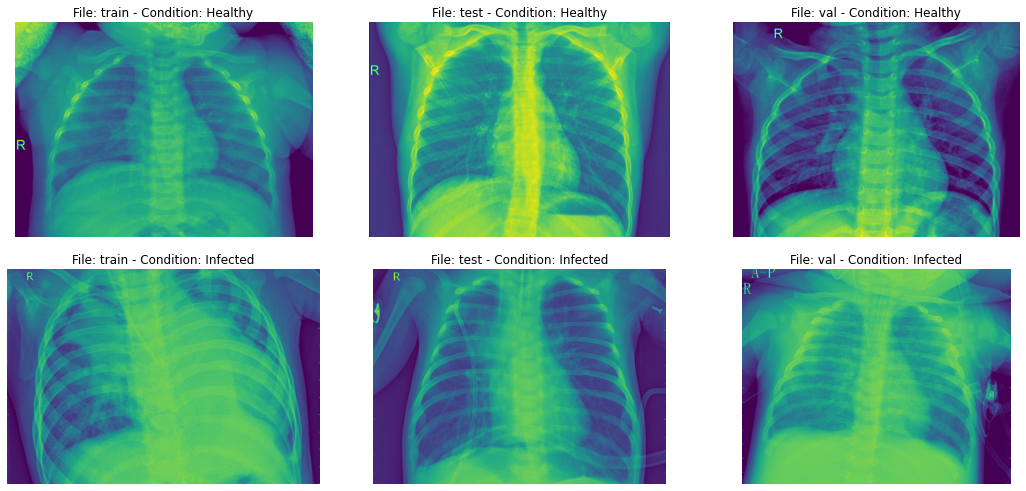

In [6]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train','test','val']):
    set_path = input_dir+_set
    ax[i].axis('off')
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]))
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))
    ax[i+3].axis('off')
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]))
    ax[i+3].set_title('File: {} - Condition: Infected'.format(_set))

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
def build_model(backbone, lr=0.01):
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    model.add(Dense(1,activation="softmax"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['acc']
    )
    return model

vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(vgg16 ,lr = 0.01)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4096)              33558528  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              4

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [10]:
# Fit Model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=25,
    validation_data=test_generator,
    validation_steps=10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/25
 76/100 [=====================>........] - ETA: 15s - loss: 0.0000e+00 - accuracy: 0.7401

KeyboardInterrupt: ignored

In [ ]:
# model save
model.save_weights("vgg16-example-pneumonia.h5")

In [ ]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])